In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from util import get_ci

In [2]:
path = 'plot_df.pkl'
with open(path, 'rb') as file:
    df = pickle.load(file)    
df['Final Incorrectness'] = df['Incorrectness'].apply(lambda x : x[-1])

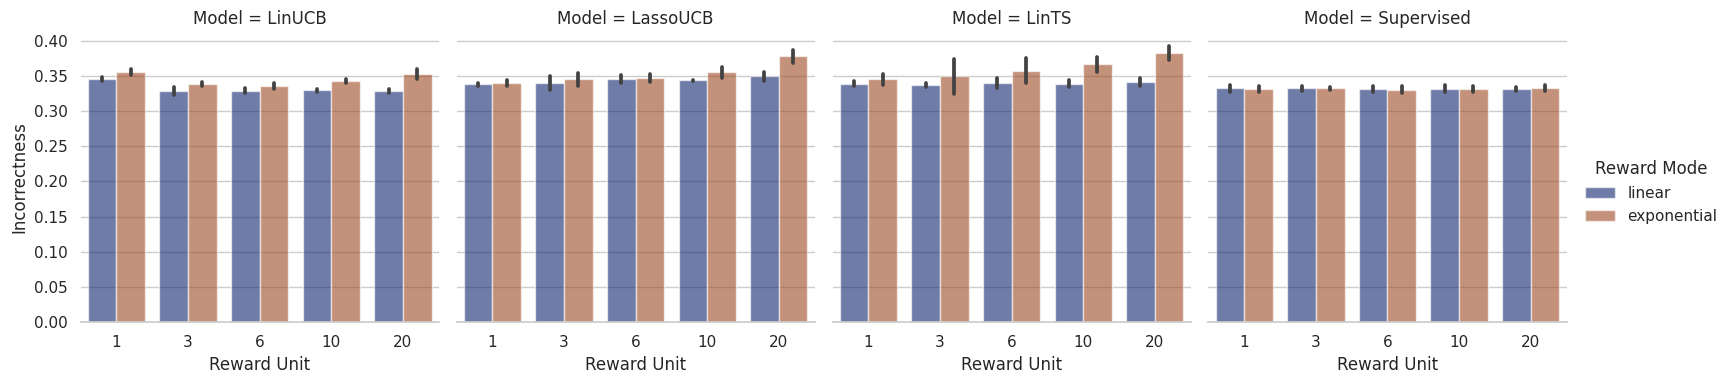

In [3]:
sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=df, kind="bar",
    x="Reward Unit", 
    y="Final Incorrectness", 
    hue="Reward Mode", 
    col="Model",
    errorbar="sd", 
    palette="dark", 
    alpha=.6, 
    height=4, 
    aspect=4/4
)
g.despine(left=True)
g.set_axis_labels("Reward Unit", "Incorrectness")
g.legend.set_title("Reward Mode")

In [14]:
plot_dts = {}
i = 0
for model in df['Model'].unique():
    plot_dts[model] = {}
    for mode in df['Reward Mode'].unique():
        for unit in df['Reward Unit'].unique():
            dt = df.loc[(df['Model']==model)&(df['Reward Mode']==mode)&(df['Reward Unit']==unit)]['Incorrectness']
            plot_dts[model][mode+' unit '+str(unit)] = np.array([i for i in dt])

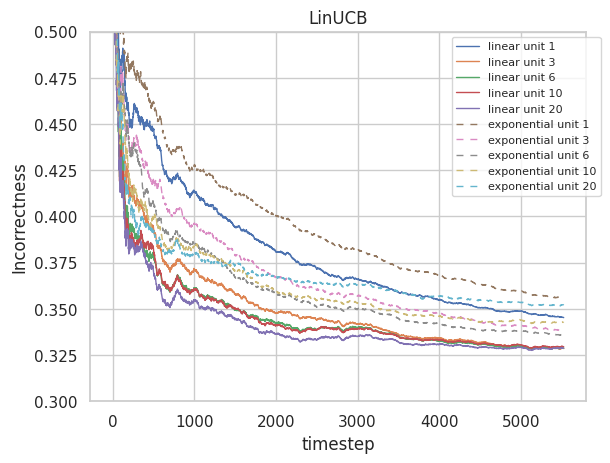

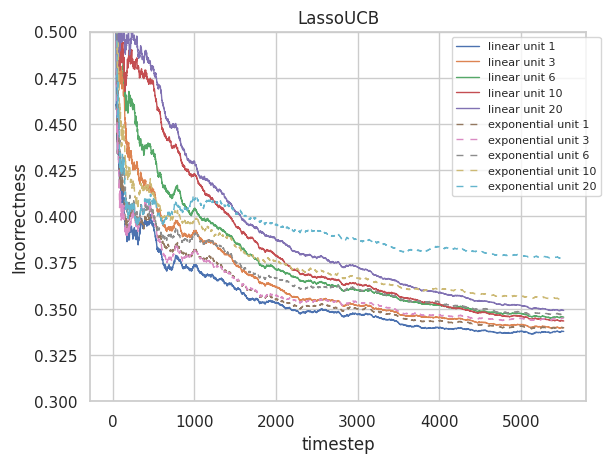

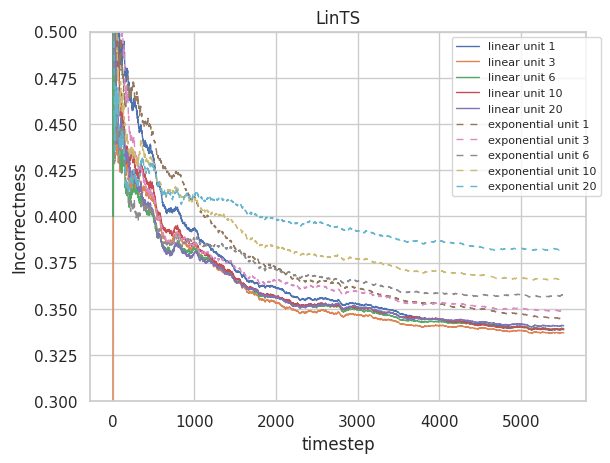

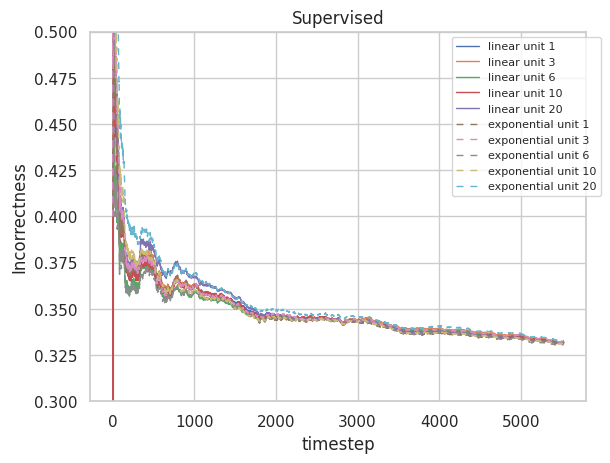

In [15]:
def plot_ci(plot_data, title, confidence=0.95):
    
    for model, dt in plot_data.items():
        T = dt.shape[1]
        means = np.apply_along_axis(np.mean, 0, dt)
        low_ci = np.apply_along_axis(get_ci, 0, dt, kind='low', confidence=confidence)
        high_ci = np.apply_along_axis(get_ci, 0, dt, kind='high', confidence=confidence)
        
        if model.startswith('exp'):
            linestyle = (0, (5, 5))
            linewidth = 1
        else:
            linestyle = None
            linewidth = 1
        
        plt.plot(range(T), means, label=model, linestyle=linestyle, linewidth=linewidth)
        # plt.fill_between(range(T), low_ci, high_ci, alpha=.1)
        
    plt.legend(bbox_to_anchor=(1.04,1), prop={'size': 8})   
    plt.ylim([0.3, 0.5])
    plt.xlabel('timestep')
    plt.ylabel('Incorrectness')
    plt.title(title)
    plt.show()

for model in plot_dts:
    plot_ci(plot_data=plot_dts[model], title=model)